In [338]:
import torch
from torch import nn
import train
import utils
from importlib import reload
reload(train)

train.set_namespace('05-resnet-03')

In [339]:
train_dl, test_dl, classes = utils.make_cifar_dataloaders_without_validation()

Files already downloaded and verified
Files already downloaded and verified


In [340]:
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34

    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers

    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block

        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer

        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [341]:
model1 = train.Model('resnet-18-01', resnet18(), '40 Adam + 40 SGD')

Trainable params: 11.2 M. Untrainable params: 0.00. Buffers: 6.00 k.


Initial val_loss=4.6057, val_accuracy=0.0100
Saved model resnet-18-01 checkpoint 0001. epoch=0, step=0. val_loss=4.6057, val_accuracy=0.0100
Epoch 1/40: train_loss=3.7950, train_accuracy=0.1176, val_loss=3.4014, val_accuracy=0.1775
Saved model resnet-18-01 checkpoint 0001. epoch=1, step=782. train_loss=3.7950, train_accuracy=0.1176, val_loss=3.4014, val_accuracy=0.1775
Epoch 2/40: train_loss=3.0072, train_accuracy=0.2466, val_loss=3.0533, val_accuracy=0.2624
Saved model resnet-18-01 checkpoint 0001. epoch=2, step=1564. train_loss=3.0072, train_accuracy=0.2466, val_loss=3.0533, val_accuracy=0.2624
Epoch 3/40: train_loss=2.5283, train_accuracy=0.3388, val_loss=2.6266, val_accuracy=0.3378
Saved model resnet-18-01 checkpoint 0001. epoch=3, step=2346. train_loss=2.5283, train_accuracy=0.3388, val_loss=2.6266, val_accuracy=0.3378
Epoch 4/40: train_loss=2.2461, train_accuracy=0.3994, val_loss=2.2571, val_accuracy=0.4102
Saved model resnet-18-01 checkpoint 0001. epoch=4, step=3128. train_loss=

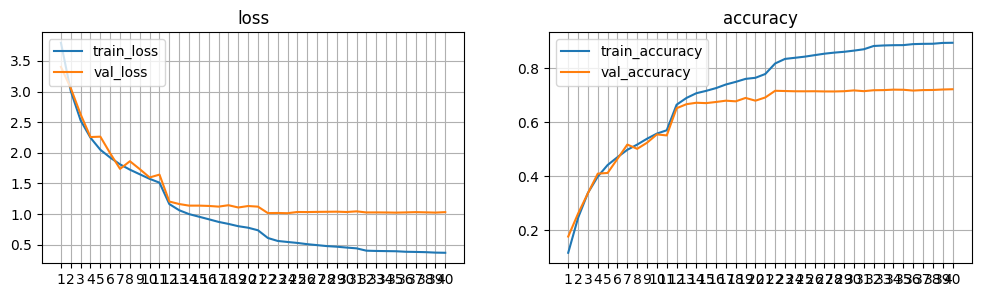

In [342]:
with model1.checkpoint(1, '40 Adam without load_best') as cp:
    cp.setup(
        loss_cls=torch.nn.CrossEntropyLoss, 
        optimizer_cls=torch.optim.Adam,
        optimizer_args=dict(lr=5e-4, weight_decay=5e-4),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=10, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=False, epochs=40, metrics=[train.metric_accuracy])
    cp.plot_metrics()


In [374]:
model2 = train.Model('resnet-18-02', resnet18(), '40 Adam with reversion')
model2.delete()
model2_state_dict = model2.model.state_dict()

Trainable params: 11.2 M. Untrainable params: 0.00. Buffers: 6.00 k.


In [375]:
model3 = resnet18()
model3.load_state_dict(model2_state_dict)
model3 = train.Model('resnet-18-03', model3)

Trainable params: 11.2 M. Untrainable params: 0.00. Buffers: 6.00 k.


In [376]:
with model2.checkpoint('0001') as cp:
    cp.setup(
        loss_cls=torch.nn.CrossEntropyLoss, 
        optimizer_cls=torch.optim.Adam,
        optimizer_args=dict(lr=5e-4, weight_decay=5e-4),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=10, gamma=0.2)
    )

    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=1, metrics=[train.metric_accuracy])


Initial val_loss=4.6059, val_accuracy=0.0122
Saved model resnet-18-02 checkpoint 0001. epoch=0, step=0. val_loss=4.6059, val_accuracy=0.0122


100%|██████████| 157/157 [00:02<00:00, 52.48it/s]


Epoch 1/1: train_loss=3.7844, train_accuracy=0.1181, val_loss=3.3758, val_accuracy=0.1785
Saved model resnet-18-02 checkpoint 0001. epoch=1, step=782. train_loss=3.7844, train_accuracy=0.1181, val_loss=3.3758, val_accuracy=0.1785
Loaded model resnet-18-02 from checkpoint 0001. epoch=1, step=782. train_loss=3.7844, train_accuracy=0.1181, val_loss=3.3758, val_accuracy=0.1785


In [377]:
model4 = resnet18()
model4.load_state_dict(model2_state_dict)
model4 = train.Model('resnet-18-03', model4)

Trainable params: 11.2 M. Untrainable params: 0.00. Buffers: 6.00 k.


In [378]:
model2.evaluate(test_dl, loss_cls=torch.nn.CrossEntropyLoss)

{'loss': 3.3758098190307617}

In [379]:
model3.evaluate(test_dl, loss_cls=torch.nn.CrossEntropyLoss)

{'loss': 4.605880838012696}

In [380]:
model4.evaluate(test_dl, loss_cls=torch.nn.CrossEntropyLoss)

{'loss': 3.3758098190307617}

In [350]:
with model2.checkpoint('0001', '40 Adams, with reversion') as cp:
    cp.setup(
        loss_cls=torch.nn.CrossEntropyLoss, 
        optimizer_cls=torch.optim.Adam,
        optimizer_args=dict(lr=5e-4, weight_decay=5e-4),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=10, gamma=0.2)
    )
    
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.plot_metrics()

KeyboardInterrupt: 

Initial val_loss=1.0321, val_accuracy=0.7224
Saved model resnet-18-01 checkpoint 0002. epoch=40, step=31280. val_loss=1.0321, val_accuracy=0.7224
Epoch 1/40: train_loss=0.3699, train_accuracy=0.8958, val_loss=1.0304, val_accuracy=0.7204
Epoch 2/40: train_loss=0.3690, train_accuracy=0.8936, val_loss=1.0304, val_accuracy=0.7220
Epoch 3/40: train_loss=0.3690, train_accuracy=0.8940, val_loss=1.0279, val_accuracy=0.7215
Epoch 4/40: train_loss=0.3635, train_accuracy=0.8960, val_loss=1.0343, val_accuracy=0.7204
Epoch 5/40: train_loss=0.3629, train_accuracy=0.8968, val_loss=1.0348, val_accuracy=0.7192
Epoch 6/40: train_loss=0.3597, train_accuracy=0.8970, val_loss=1.0316, val_accuracy=0.7201
Epoch 7/40: train_loss=0.3541, train_accuracy=0.8983, val_loss=1.0413, val_accuracy=0.7195
Epoch 8/40: train_loss=0.3490, train_accuracy=0.8994, val_loss=1.0417, val_accuracy=0.7194
Epoch 9/40: train_loss=0.3479, train_accuracy=0.9003, val_loss=1.0403, val_accuracy=0.7205
Epoch 10/40: train_loss=0.3462, tra

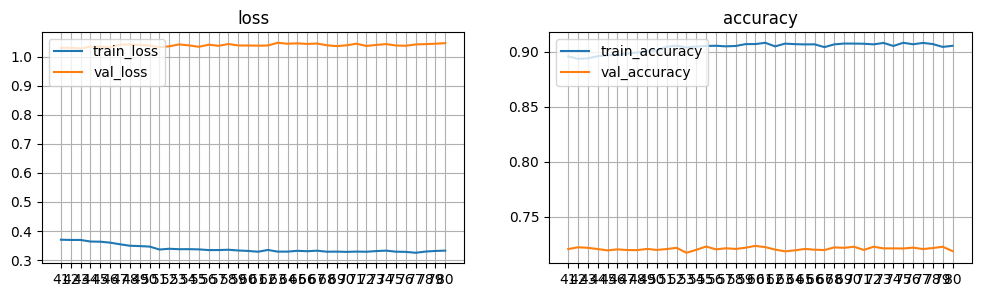

In [52]:
with model1.checkpoint(2, '40 SGD from latest Adam') as cp:
    cp.setup(
        optimizer_cls=torch.optim.SGD,
        optimizer_args=dict(lr=0.1 * 0.2 ** 4, weight_decay=5e-4, momentum=0.9),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=10, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=40, metrics=[train.metric_accuracy])
    cp.plot_metrics()


In [53]:
model1.evaluate(test_dl, metrics=[train.metric_accuracy])

{'loss': 1.038344052028656, 'accuracy': 0.7233}

In [54]:
model1.load_checkpoint(1, from_backup=True)

Backup for model resnet-18-01 checkpoint 1 does not exist. Trying from latest.
Loaded model resnet-18-01 from checkpoint 1. epoch=40, step=31280. train_loss=0.3692, train_accuracy=0.8943, val_loss=1.0321, val_accuracy=0.7224


Initial val_loss=1.0321, val_accuracy=0.7224
Saved model resnet-18-01 checkpoint 0001-02. epoch=40, step=31280. val_loss=1.0321, val_accuracy=0.7224
Epoch 1/10: train_loss=0.3695, train_accuracy=0.8942, val_loss=1.0285, val_accuracy=0.7222
Epoch 2/10: train_loss=0.3607, train_accuracy=0.8968, val_loss=1.0279, val_accuracy=0.7215
Epoch 3/10: train_loss=0.3602, train_accuracy=0.8982, val_loss=1.0288, val_accuracy=0.7206
Epoch 4/10: train_loss=0.3617, train_accuracy=0.8984, val_loss=1.0334, val_accuracy=0.7220
Epoch 5/10: train_loss=0.3608, train_accuracy=0.8973, val_loss=1.0238, val_accuracy=0.7212
Epoch 6/10: train_loss=0.3581, train_accuracy=0.8992, val_loss=1.0338, val_accuracy=0.7203
Epoch 7/10: train_loss=0.3627, train_accuracy=0.8959, val_loss=1.0291, val_accuracy=0.7223
Epoch 8/10: train_loss=0.3589, train_accuracy=0.8985, val_loss=1.0319, val_accuracy=0.7206
Epoch 9/10: train_loss=0.3605, train_accuracy=0.8966, val_loss=1.0289, val_accuracy=0.7210
Epoch 10/10: train_loss=0.3567, 

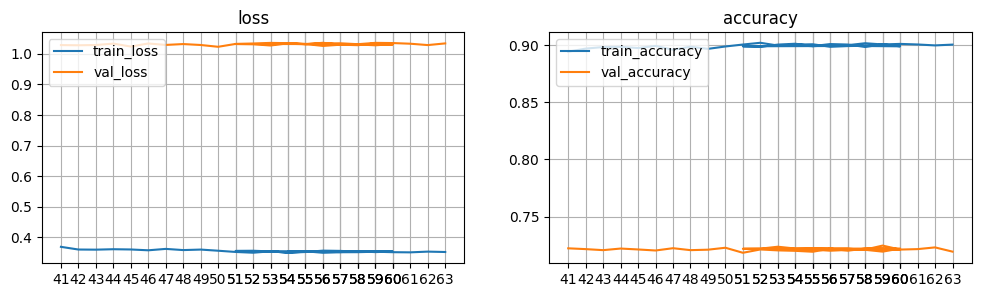

In [55]:
with model1.checkpoint('0001-02', 'Additional 40 Adams, with reversion') as cp:
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.plot_metrics()

Backup for model resnet-18-01 checkpoint 1 does not exist. Trying from latest.
Loaded model resnet-18-01 from checkpoint 1. epoch=40, step=31280. train_loss=0.3692, train_accuracy=0.8943, val_loss=1.0321, val_accuracy=0.7224
Initial val_loss=1.0321, val_accuracy=0.7224
Saved model resnet-18-01 checkpoint 0001-03. epoch=40, step=31280. val_loss=1.0321, val_accuracy=0.7224
Epoch 1/40: train_loss=0.3702, train_accuracy=0.8920, val_loss=1.0267, val_accuracy=0.7213
Epoch 2/40: train_loss=0.3616, train_accuracy=0.8979, val_loss=1.0369, val_accuracy=0.7183
Epoch 3/40: train_loss=0.3613, train_accuracy=0.8981, val_loss=1.0273, val_accuracy=0.7198
Epoch 4/40: train_loss=0.3603, train_accuracy=0.8975, val_loss=1.0296, val_accuracy=0.7215
Epoch 5/40: train_loss=0.3586, train_accuracy=0.8982, val_loss=1.0290, val_accuracy=0.7227
Saved model resnet-18-01 checkpoint 0001-03. epoch=45, step=35190. train_loss=0.3586, train_accuracy=0.8982, val_loss=1.0290, val_accuracy=0.7227
Epoch 6/40: train_loss=0.

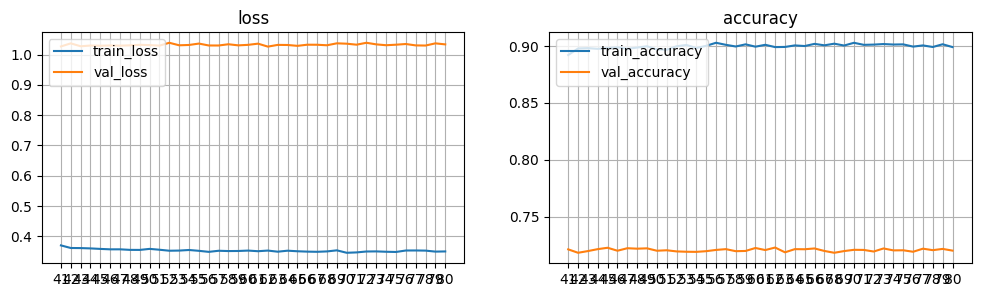

In [56]:
model1.load_checkpoint(1, from_backup=True)
with model1.checkpoint('0001-03', 'Additional 40 Adams, without reversion') as cp:
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=40, metrics=[train.metric_accuracy])
    cp.plot_metrics()